In [2]:
#pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.

In [62]:
# Ejemplo univariado LSTM
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential # para construir modelos de redes neuronales de manera secuencial capa por capa.
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense #cada neurona está conectada a todas las neuronas de la capa anterior.
from tensorflow.keras.layers import Flatten # Su propósito es aplanar (flatten) los datos multidimensionales de entrada en una única dimensión.
from array import array

# Función que servirá para la transformación de datos:

In [4]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):

	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		# ej = 110,125,133 es "x" / end_ix= 146
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# 1. Recopilación y exploración de datos:

Importación de serie

In [7]:
local = 'C:/Users/Josvaldes/Documents/Maestria/Austral/2ano/analisisST/TP1/SerieT/ST-main/ST-main/Datos históricos Bitcoin 2013.csv'


In [11]:
# Especifica el formato de fecha personalizado para 'Fecha' (DD.MM.YYYY)
date_parser = lambda x: pd.to_datetime(x, format='%d.%m.%Y')

# Lee el archivo CSV con el formato de fecha personalizado
serie = pd.read_csv(local, index_col='Fecha', parse_dates=True, date_parser=date_parser)
serie = serie.asfreq('D')
serie_indice = pd.read_csv(local, parse_dates=True, date_parser=date_parser)

C:\Users\Josvaldes\AppData\Local\Temp\ipykernel_23256\1381671639.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  serie = pd.read_csv(local, index_col='Fecha', parse_dates=True, date_parser=date_parser)
C:\Users\Josvaldes\AppData\Local\Temp\ipykernel_23256\1381671639.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  serie_indice = pd.read_csv(local, parse_dates=True, date_parser=date_parser)


In [12]:
#Visualización de la serie de datos
serie.head()

,Último,Apertura,Máximo,Mínimo,Vol.,% var.
Fecha,,,,,,
2013-02-01,"20,5","20,4","21,1","20,3","49,92K","0,44%"
2013-02-02,"19,6","20,5","20,5","18,0","80,50K","-4,24%"
2013-02-03,"20,6","19,6","20,9","19,4","34,24K","4,89%"
2013-02-04,"20,4","20,6","21,0","19,9","52,22K","-0,78%"
2013-02-05,"20,6","20,4","20,8","20,2","29,21K","0,83%"


In [13]:
# dimensiones del dataset
serie.shape


(3918, 6)

In [14]:
# Se eliminan datos que no son necesarios para el analisis
btc_ts=serie.drop(['Apertura','Máximo','Mínimo','Vol.','% var.'], axis=1)

In [15]:
btc_ts.head()

,Último
Fecha,
2013-02-01,"20,5"
2013-02-02,"19,6"
2013-02-03,"20,6"
2013-02-04,"20,4"
2013-02-05,"20,6"


In [16]:
# Verificamos si hay nulos
print(btc_ts.isnull().values.any())

False


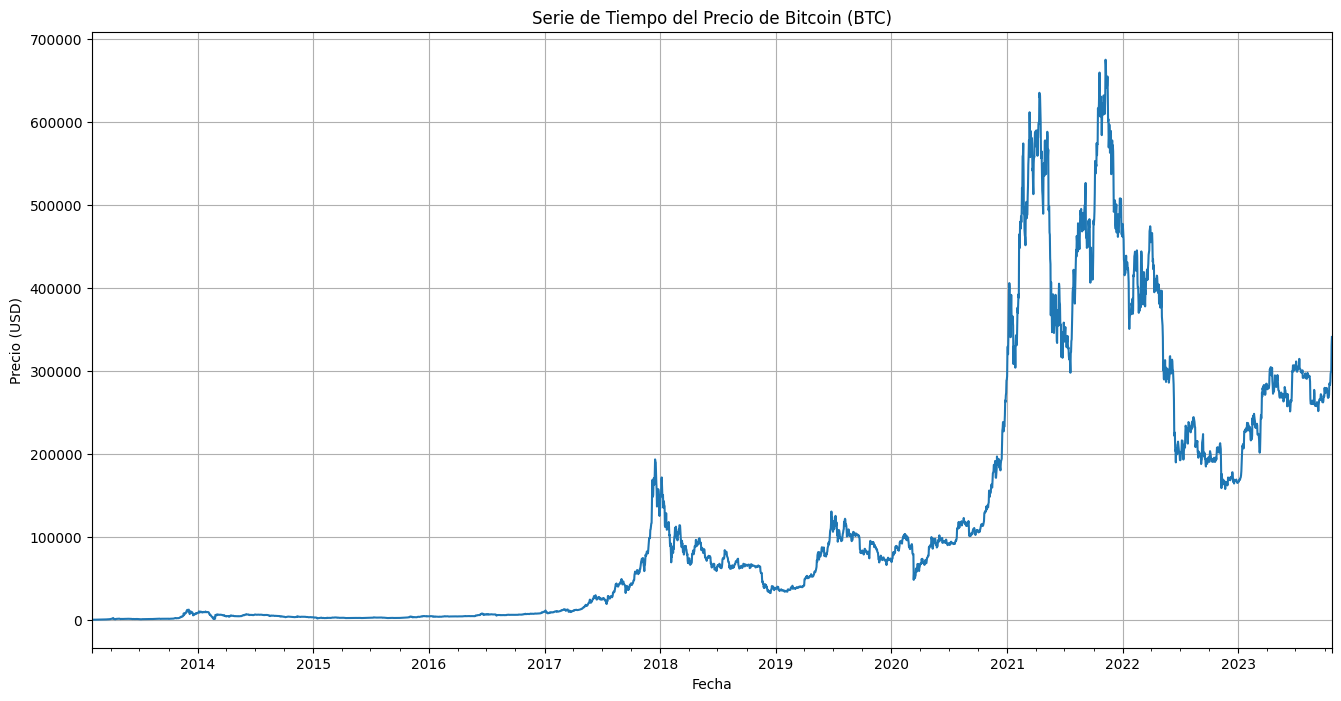

In [18]:
# Importacion para visualización
from matplotlib import pyplot as plt

# Convierte la columna 'Último' en cadenas
btc_ts['Último'] = btc_ts['Último'].astype(str)

# Reemplaza los puntos por nada (eliminar los puntos) y luego reemplaza las comas por puntos decimales
btc_ts['Último'] = btc_ts['Último'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Crea una serie de tiempo con la columna 'Último'
serie_tiempo = pd.Series(btc_ts['Último'].values, index=pd.to_datetime(btc_ts.index))

# Trama la serie de tiempo
serie_tiempo.plot(figsize=(16, 8))
plt.title('Serie de Tiempo del Precio de Bitcoin (BTC)')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.grid(True)
plt.show()

El grafico hace referencia al precio del Bitcoin entre el periodo de 2014 al 2023. Los procesos de precios, por lo general, tienen un comportamiento "RANDOM WALK" (camino aleatorio). El mismo es un proceso en el que una variable cambia de manera aleatoria en cada paso de tiempo, sin seguir un patrón predecible. Es un modelo que representa cambios impredecibles en datos a lo largo del tiempo.

In [20]:
# define input sequence
timeseries_data = serie_tiempo
# choose a number of time steps
n_steps = 3
# split into samples
# preparo las variables dependientes e independientes.
X, y = prepare_data(timeseries_data, n_steps)

In [21]:
print(X)

[[2.05000e+02 1.96000e+02 2.06000e+02]
 [1.96000e+02 2.06000e+02 2.04000e+02]
 [2.06000e+02 2.04000e+02 2.06000e+02]
 ...
 [2.87230e+05 2.96745e+05 2.99129e+05]
 [2.96745e+05 2.99129e+05 2.99842e+05]
 [2.99129e+05 2.99842e+05 3.30418e+05]]


In [22]:
X.shape

(3915, 3)

In [23]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1  # para convertir X en una variable de 3 dimensiones.Este valor indica el número de características en la entrada,
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [24]:
X

array([[[2.05000e+02],
        [1.96000e+02],
        [2.06000e+02]],

       [[1.96000e+02],
        [2.06000e+02],
        [2.04000e+02]],

       [[2.06000e+02],
        [2.04000e+02],
        [2.06000e+02]],

       ...,

       [[2.87230e+05],
        [2.96745e+05],
        [2.99129e+05]],

       [[2.96745e+05],
        [2.99129e+05],
        [2.99842e+05]],

       [[2.99129e+05],
        [2.99842e+05],
        [3.30418e+05]]])

In [25]:
X.shape

(3915, 3, 1)

# 2. Construcción del modelo LSTM

In [26]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))     # return_sequences=True, input_shape=(n_steps, n_features)))
# model.add(LSTM(50, activation='relu')) - Rectified Linear Unit (o unidad lineal rectificada)
model.add(Dense(1))  # output node
model.compile(optimizer='Nadam', loss='mse') #Indica el algoritmo de descenso de gradiente que vamos a usar junto con la tasa de aprendizaje o learning_rate

# fit model
model.fit(X, y, epochs=50, verbose=1) # Epoch. Este es el numero de veces que se ejecutaran los algoritmos



Epoch 1/50

123/123 [==============================] - 2s 2ms/step - loss: 15363281920.0000
Epoch 2/50
123/123 [==============================] - 0s 2ms/step - loss: 94833168.0000
Epoch 3/50
123/123 [==============================] - 0s 2ms/step - loss: 93096848.0000
Epoch 4/50
123/123 [==============================] - 0s 2ms/step - loss: 92786008.0000
Epoch 5/50
123/123 [==============================] - 0s 2ms/step - loss: 95280208.0000
Epoch 6/50
123/123 [==============================] - 0s 2ms/step - loss: 90745680.0000
Epoch 7/50
123/123 [==============================] - 0s 2ms/step - loss: 89860344.0000
Epoch 8/50
123/123 [==============================] - 0s 2ms/step - loss: 88765224.0000
Epoch 9/50
123/123 [==============================] - 0s 2ms/step - loss: 90402512.0000
Epoch 10/50
123/123 [==============================] - 0s 2ms/step - loss: 88185584.0000
Epoch 11/50
123/123 [==============================] - 0s 2ms/step - loss: 88704080.0000
Epoch 12/50
123/123 [===

# 3. Predicción: horizonte temporal de 10 días:

In [34]:
# Output para un horizonte temporal de 10 dias

import numpy as np

x_input = np.array([299129, 299842, 330418])
temp_input=list(x_input)
lst_output=[]
i=0
while(i<10):

    if(len(temp_input)>3):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1


print(lst_output)

[313111.78]
1 day input [299842.      330418.      313111.78125]
1 day output [[320271.34]]
2 day input [330418.      313111.78125 320271.34375]
2 day output [[315437.88]]
3 day input [313111.78 320271.34 315437.88]
3 day output [[316473.8]]
4 day input [320271.34 315437.88 316473.8 ]
4 day output [[314643.3]]
5 day input [315437.88 316473.8  314643.3 ]
5 day output [[314218.22]]
6 day input [316473.8  314643.3  314218.22]
6 day output [[313109.6]]
7 day input [314643.3  314218.22 313109.6 ]
7 day output [[312338.94]]
8 day input [314218.22 313109.6  312338.94]
8 day output [[311406.66]]
9 day input [313109.6  312338.94 311406.66]
9 day output [[310557.16]]
[313111.78, 320271.34, 315437.88, 316473.8, 314643.3, 314218.22, 313109.6, 312338.94, 311406.66, 310557.16]


In [35]:
timeseries_data

Fecha
2013-02-01       205.0
2013-02-02       196.0
2013-02-03       206.0
2013-02-04       204.0
2013-02-05       206.0
                ...   
2023-10-20    296745.0
2023-10-21    299129.0
2023-10-22    299842.0
2023-10-23    330418.0
2023-10-24    341061.0
Freq: D, Length: 3918, dtype: float64

In [36]:
len(timeseries_data)

3918

# 4. Vizualizamos el output

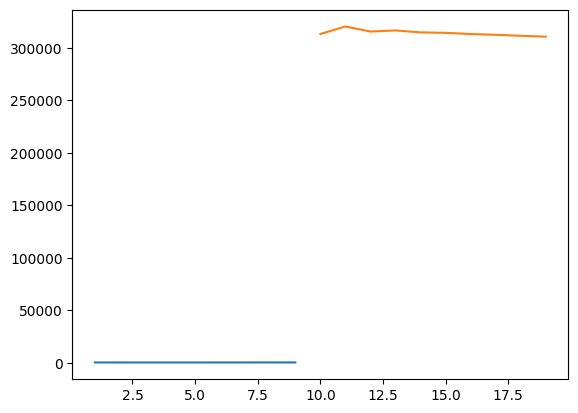

In [37]:
import matplotlib.pyplot as plt
day_new=np.arange(1,10)
day_pred=np.arange(10,20)

plt.plot(day_new,timeseries_data[:9])
plt.plot(day_pred,lst_output)

In [38]:
df_time_diffs = serie_tiempo.index.to_series().diff().dt.total_seconds() #total_seconds es una función de pandas que retorna la duración total de cada elemento expresada en segundos.
print(df_time_diffs.value_counts())

Fecha
86400.0    3917
Name: count, dtype: int64


Todos los datos estan con una diferencia de 24 horas.

In [40]:
serie_tiempo.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3918 entries, 2013-02-01 to 2023-10-24
Freq: D
Series name: None
Non-Null Count  Dtype  
--------------  -----  
3918 non-null   float64
dtypes: float64(1)
memory usage: 61.2 KB


In [39]:
serie_tiempo.shape


(3918,)

# 5. Modelo univariado-unistep

In [43]:
#Función para división de la serie
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

In [46]:
tr, vl, ts = train_val_test_split(serie_tiempo)

# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (3134,)
Tamaño set de validación: (391,)
Tamaño set de prueba: (393,)


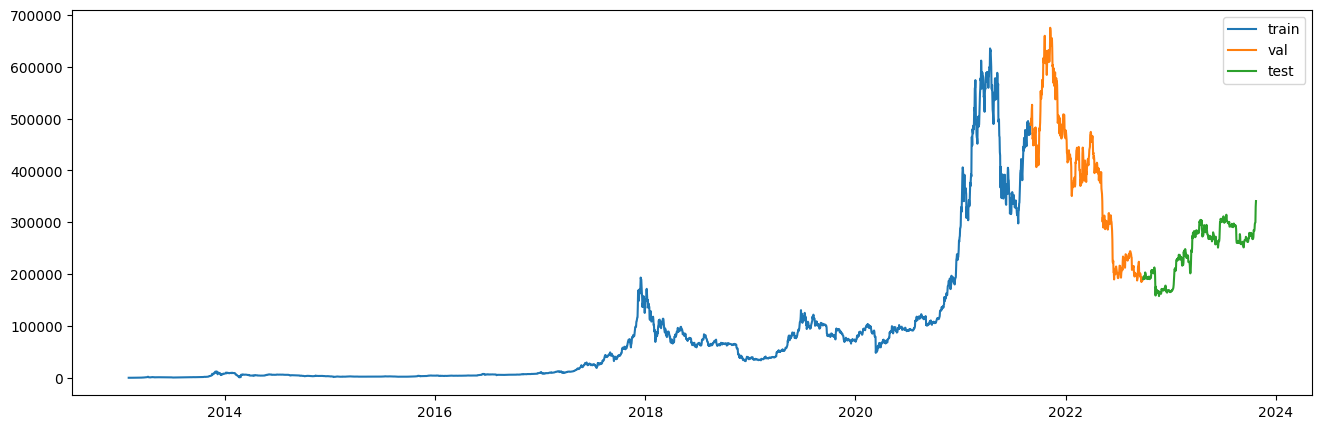

In [48]:
# Grafica de la división de la serie
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(tr,label="train")
ax.plot(vl,label="val")
ax.plot(ts,label="test")
plt.legend()

# 5.1. Adecuación para una red LSTM: Dataset supervisado

In [50]:
# Función para el pre procesamiento de los datos en las divisiones realizadas
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos (utilizando ventanas deslizantes de longitud input_length)
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [51]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 24    # Registros de 240 min consecutivos a la entrada
OUTPUT_LENGTH = 1    # El modelo va a predecir 10 min a futuro

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

In [52]:
# Visualización
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (3109, 24, 1), y_tr: (3109, 1, 1)
Set de validación - x_vl: (366, 24, 1), y_vl: (366, 1, 1)
Set de prueba - x_ts: (368, 24, 1), y_ts: (368, 1, 1)


# 5.2. Escalamiento de los datos

In [56]:
# Función de escalamiento de datos
from sklearn.preprocessing import MinMaxScaler


def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados (Se crean arreglos vacíos con las mismas dimensiones que los conjuntos de datos originales para almacenar los datos escalados)
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs (aca es una sola feature, pero en un multivariado ya nos quedará a estructura)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i]) #ajustamos a los datos de entrenamiento
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i]) #transformamos con el ajuste a val y a test tomando el rango del set de entrenamiento
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (Se asume que las etiquetas se encuentran en la última columna de los conjuntos de datos...ademas, en este caso es una sola columna)
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0] #útil para realizar la inversión de escalamiento

In [57]:
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

In [58]:
data_s, scaler = escalar_dataset(data_in)

In [59]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [60]:
# Validación de los datos escalados
print(f'Min x_tr/x_vl/x_ts sin escalamiento:  {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento:  {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'Min y_tr/y_vl/y_ts sin escalamiento:  {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento:  {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'Max x_tr/x_vl/x_ts sin escalamiento:  {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento:  {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'Max y_tr/y_vl/y_ts sin escalamiento:  {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento:  {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')


Min x_tr/x_vl/x_ts sin escalamiento:  196.0/184890.0/157762.0
Min x_tr/x_vl/x_ts con escalamiento:  -1.0/-0.4187117192297397/-0.5041394404118972
Min y_tr/y_vl/y_ts sin escalamiento:  304.0/184890.0/157762.0
Min y_tr/y_vl/y_ts con escalamiento:  -1.0/-0.4187228883412979/-0.5041512820714684
Max x_tr/x_vl/x_ts sin escalamiento:  635409.0/675279.0/314661.0
Max x_tr/x_vl/x_ts con escalamiento:  1.0000000000000002/1.1255530538017038/-0.009891170363327095
Max y_tr/y_vl/y_ts sin escalamiento:  635409.0/675279.0/330418.0
Max y_tr/y_vl/y_ts con escalamiento:  1.0000000000000002/1.125554042244983/0.03955723856685123


# 5.3. Creación y entrenamiento de la Red LSTM

In [69]:
import tensorflow as tf

tf.random.set_seed(123) #para garantizar la reproducibidad del entrenamiento

N_UNITS = 128 #número de unidades del modelo (que corresponde al tamaño del estado oculto y a la celda de memoria de la Red LSTM.
#hiperparámetro del modelo a afinar

INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) #cada uno de los datos de entrada será un arreglo de tamaño 24 (xxx minutos de entrada) x 1 (feature).

modelo2 = Sequential() #caja vacía a la cual se le adicionaran de manera secuencial los elementos
modelo2.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo2.add(Dense(OUTPUT_LENGTH, activation='linear'))

# 5.4. Compilación del modelo

In [70]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

In [71]:
from tensorflow.keras.optimizers import RMSprop

optimizador = RMSprop(learning_rate=5e-5)

In [72]:
modelo2.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# 5.5. Entrenamiento del modelo

In [73]:
EPOCHS = 80 #iteraciones de entrenamiento
BATCH_SIZE = 256 #tamaño del lote (es decir, 256 datos de entrenamiento en cada iteración)

In [75]:
historia = modelo2.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2 #vemos como evoluciona el entrenamiento
)

Epoch 1/80
13/13 - 3s - loss: 0.8688 - val_loss: 0.4495 - 3s/epoch - 195ms/step
Epoch 2/80
13/13 - 1s - loss: 0.7635 - val_loss: 0.4134 - 604ms/epoch - 46ms/step
Epoch 3/80
13/13 - 1s - loss: 0.6684 - val_loss: 0.3770 - 609ms/epoch - 47ms/step
Epoch 4/80
13/13 - 1s - loss: 0.5657 - val_loss: 0.3384 - 609ms/epoch - 47ms/step
Epoch 5/80
13/13 - 1s - loss: 0.4491 - val_loss: 0.2968 - 926ms/epoch - 71ms/step
Epoch 6/80
13/13 - 1s - loss: 0.3118 - val_loss: 0.2538 - 898ms/epoch - 69ms/step
Epoch 7/80
13/13 - 1s - loss: 0.1597 - val_loss: 0.2264 - 698ms/epoch - 54ms/step
Epoch 8/80
13/13 - 1s - loss: 0.0906 - val_loss: 0.2120 - 1s/epoch - 79ms/step
Epoch 9/80
